<a href="https://colab.research.google.com/github/Banben07/Banben07/blob/main/ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyts
!pip install wfdb

In [ ]:
import os
import datetime
import wfdb
import pywt
import seaborn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
from sklearn.metrics import confusion_matrix

# 项目目录
project_path = '/content/drive/MyDrive/ECG_Classification'
# 定义日志目录,必须是启动web应用时指定目录的子目录,建议使用日期时间作为子目录名
log_dir = project_path + 'logs\\' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
model_path = project_path + 'ecg_model.h5'

# 测试集在数据集中所占的比例
RATIO = 0.3



# 小波去噪预处理
def denoise(data):
    # 小波变换
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    # 阈值去噪
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    # 小波反变换,获取去噪后的信号
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')

    return rdata


# 读取心电数据和对应标签,并对数据进行小波去噪
def getDataSet(number, X_data, Y_data):
    ecgClassSet = ['N', 'A', 'V', 'L', 'R']

    # 读取心电数据记录
    print('正在读取' + number + ' 号心电数据...')
    record = wfdb.rdrecord('/content/drive/MyDrive/ECG_Classification/ecg_data/' + number, channel_names=['MLII'])
    data = record.p_signal.flatten()
    rdata = denoise(data=data)

    # 获取心电数据记录中R波的位置和对应的标签
    annotation = wfdb.rdann('/content/drive/MyDrive/ECG_Classification/ecg_data/' + number, 'atr')
    Rlocation = annotation.sample
    Rclass = annotation.symbol

    # 去掉前后的不稳定数据
    start = 10
    end = 5
    i = start
    j = len(annotation.symbol) - end

    # 因为只选择NAVLR五种心电类型,所以要选出该条记录中所需要的那些带有特定标签的数据,舍弃其余标签的点
    # X_data在R波前后截取长度为300的数据点
    # Y_data将NAVLR按顺序转换为01234
    while i < j:
        try:
            lable = ecgClassSet.index(Rclass[i])
            x_train = rdata[Rlocation[i] - 99:Rlocation[i] + 201]
            X_data.append(x_train)
            Y_data.append(lable)
            i += 1
        except ValueError:
            i += 1

    return


# 加载数据集并进行预处理
def loadData():
    numberSet = ['100', '101', '103', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115',
                 '116', '117', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '208',
                 '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230',
                 '231', '232', '233', '234']
    dataSet = []
    lableSet = []
    for n in numberSet:
        getDataSet(n, dataSet, lableSet)

    # 转numpy数组,打乱顺序
    dataSet = np.array(dataSet).reshape(-1, 300)
    lableSet = np.array(lableSet).reshape(-1, 1)
    train_ds = np.hstack((dataSet, lableSet))
    np.random.shuffle(train_ds)

    # 数据集及其标签集
    X = train_ds[:, :300].reshape(-1, 300, 1)
    Y = train_ds[:, 300]

    # 测试集及其标签集
    shuffle_index = np.random.permutation(len(X))
    test_length = int(RATIO * len(shuffle_index))
    test_index = shuffle_index[:test_length]
    train_index = shuffle_index[test_length:]
    X_test, Y_test = X[test_index], Y[test_index]
    X_train, Y_train = X[train_index], Y[train_index]
    return X_train, Y_train, X_test, Y_test


# 构建CNN模型
def buildModel():
    newModel = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(300, 1)),
        # 第一个卷积层, 4 个 21x1 卷积核
        tf.keras.layers.Conv1D(filters=4, kernel_size=21, strides=1, padding='SAME', activation='relu'),
        # 第一个池化层, 最大池化,4 个 3x1 卷积核, 步长为 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='SAME'),
        # 第二个卷积层, 16 个 23x1 卷积核
        tf.keras.layers.Conv1D(filters=16, kernel_size=23, strides=1, padding='SAME', activation='relu'),
        # 第二个池化层, 最大池化,4 个 3x1 卷积核, 步长为 2
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='SAME'),
        # 第三个卷积层, 32 个 25x1 卷积核
        tf.keras.layers.Conv1D(filters=32, kernel_size=25, strides=1, padding='SAME', activation='relu'),
        # 第三个池化层, 平均池化,4 个 3x1 卷积核, 步长为 2
        tf.keras.layers.AvgPool1D(pool_size=3, strides=2, padding='SAME'),
        # 第四个卷积层, 64 个 27x1 卷积核
        tf.keras.layers.Conv1D(filters=64, kernel_size=27, strides=1, padding='SAME', activation='relu'),
        # 打平层,方便全连接层处理
        tf.keras.layers.Flatten(),
        # 全连接层,128 个节点
        tf.keras.layers.Dense(128, activation='relu'),
        # Dropout层,dropout = 0.2
        tf.keras.layers.Dropout(rate=0.2),
        # 全连接层,5 个节点
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    return newModel


# 混淆矩阵
def plotHeatMap(Y_test, Y_pred):
    con_mat = confusion_matrix(Y_test, Y_pred)
    # 归一化
    # con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]
    # con_mat_norm = np.around(con_mat_norm, decimals=2)

    # 绘图
    plt.figure(figsize=(8, 8))
    seaborn.heatmap(con_mat, annot=True, fmt='.20g', cmap='Blues')
    plt.ylim(0, 5)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()


def main():
    # X_train,Y_train为所有的数据集和标签集
    # X_test,Y_test为拆分的测试集和标签集
    X_train, Y_train, X_test, Y_test = loadData()

    if os.path.exists(model_path):
        # 导入训练好的模型
        model = tf.keras.models.load_model(filepath=model_path)
    else:
        # 构建CNN模型
        model = buildModel()
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        model.summary()
        # 定义TensorBoard对象
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        # 训练与验证
        model.fit(X_train, Y_train, epochs=30,
                  batch_size=128,
                  validation_split=RATIO,
                  callbacks=[tensorboard_callback])
        model.save(filepath=model_path)

    # 预测

    predict_x = model.predict(X_test) 
    Y_pred = np.argmax(predict_x,axis=1)
    # 绘制混淆矩阵
    plotHeatMap(Y_test, Y_pred)


if __name__ == '__main__':
    main()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
正在读取 100 号心电数据...
snr =  -12.538088642149187
rmse =  0.027710570191976095


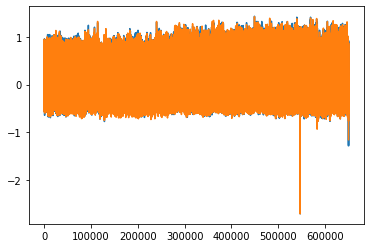

Y =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

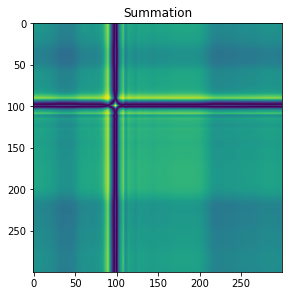

In [2]:
# 读取编号为n的一条心电数据
import pywt
import wfdb
import math
from sklearn.metrics import mean_squared_error 
import numpy as np
from matplotlib import pyplot as plt
from pyts.image import GramianAngularField
from google.colab import drive
drive.mount('/content/drive')


def OneDenoise(data,wavelet):

    # 一维小波变换
    coeffs = pywt.wavedec(data=data, wavelet=wavelet, level=6)  # wavedec()函数完成1D多阶次离散小波分解,
    # 返回系数数组list，[cAn, cDn, cDn-1, …, cD2, cD1]，n为分解阶次，cAn是逼近系数数组，后面的依次是细节系数数组。
    cA6, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    # 阈值去噪
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0) # 高频置0
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    # 小波反变换,获取去噪后的信号
    rdata = pywt.waverec(coeffs=coeffs, wavelet=wavelet)

    return rdata

def SNR_singlech(data, rdata):

    # 计算信噪比
    S = np.array(rdata) # 去噪后的信号
    SN = np.array(data) # 原始信号
    S = S - np.mean(S)  # 消除直流分量
    S = S / np.max(np.abs(S))  # 幅值归一化
    mean_S = (np.sum(S)) / (len(S))  # 纯信号的平均值
    PS = np.sum((S - mean_S) * (S - mean_S))
    PN = np.sum((S - SN) * (S - SN))
    snr = 10 * math.log((PS / PN), 10)
    return snr

def GramTrans(in_data, image_size):

    # 一维信号二维图像化
    bi_data = in_data.reshape(1, -1)
    image_size = image_size

    # 使用summation方法
    gasf = GramianAngularField(image_size=image_size, method='summation')
    out_gasf = gasf.fit_transform(bi_data)

    return out_gasf

def read_ecg_data(data):

    '''
    读取心电信号文件
    sampfrom: 设置读取心电信号的起始位置，sampfrom=0表示从0开始读取，默认从0开始
    sampto：设置读取心电信号的结束位置，sampto = 1500表示从1500出结束，默认读到文件末尾
    channel_names：设置设置读取心电信号名字，必须是列表，channel_names=['MLII']表示读取MLII导联线
    channels：设置读取第几个心电信号，必须是列表，channels=[0, 3]表示读取第0和第3个信号，注意信号数不确定
    '''

    data_path = '/content/drive/MyDrive/ECG_Classification/ecg_data/'

    # 读取“MLII”导联的信号
    print('正在读取 ' + data + ' 号心电数据...')
    record = wfdb.rdrecord(data_path + data, channel_names=['MLII'])
    data1 = record.p_signal.flatten()

    rdata = OneDenoise(data1, 'db4')

    # 计算信噪比
    snr = SNR_singlech(data1, rdata)
    # snr = np.round(snr) # 四舍五入
    print('snr = ', snr)
    
    # 计算均方根误差
    print('rmse = ', math.sqrt(mean_squared_error(data1, rdata)))

    # 画出一维图像
    plt.plot(data1)
    plt.plot(rdata)
    plt.show()

    ecgClassSet = ['N', 'A', 'V', 'L', 'R']

    # 获取心电数据记录中R波的位置和对应的标签
    annotation = wfdb.rdann('/content/drive/MyDrive/ECG_Classification/ecg_data/' + data, 'atr')
    Rlocation = annotation.sample
    Rclass = annotation.symbol

    # 去掉前后的不稳定数据
    start = 10
    end = 5
    i = start
    j = len(annotation.symbol) - end
    Y_data = []
    X_data = [] #

    # 因为只选择NAVLR五种心电类型,所以要选出该条记录中所需要的那些带有特定标签的数据,舍弃其余标签的点
    # X_data在R波前后截取长度为300的数据点
    # Y_data将NAVLR按顺序转换为01234
    while i < j:
        try:
            lable = ecgClassSet.index(Rclass[i])
            x_train = rdata[Rlocation[i] - 99:Rlocation[i] + 201]
            bi_gasf = GramTrans(x_train, 300)
            Y_data.append(lable)
            X_data.append(bi_gasf)
            i += 1
        except ValueError:
            i += 1

    dataSet = np.array(X_data).reshape(-1, 300, 300)
    labelSet= np.array(Y_data).reshape(-1, 1)

    print("Y = ", Y_data)
    print(X_data[0])
    print(dataSet[0])

    
    # 画二维
    image = X_data[0][0]
    title = 'Summation'
    fig, ax = plt.subplots(1, constrained_layout=True)
    ax.imshow(image)
    ax.set_title(title)
    plt.margins(0, 0)
    plt.show()
     
    return

'''
numberSet = ['100', '101', '103', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115',
        '116', '117', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '208',
        '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230',
        '231', '232', '233', '234']


for n in numberSet:
  read_ecg_data(data = n)
'''

read_ecg_data(data = '100')


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir("/content/drive/MyDrive/ECG_Classification/") 
!python xiaobo.py